In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab Notebooks/HW 4 Part B

/content/drive/MyDrive/Colab Notebooks/HW 4 Part B


In [1]:
import torchvision
import torch
import numpy as np
from BoxHead import *
from utils import *
from pretrained_models import *
from torchvision.models.detection.image_list import ImageList
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [2]:
# Put the path where you save the given pretrained model
pretrained_path = 'data/checkpoint680.pth'
backbone, rpn = pretrained_models_680(pretrained_path)
# load the data into data.Dataset
imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "./data/hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./data/hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path, masks_path, labels_path, bboxes_path]
dataset = BuildDataset(paths)

# Standard Dataloaders Initialization
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

# Load boxhead model
boxHead = BoxHead().cuda()
boxHead.load_state_dict(torch.load("result/epoch=39.pth"))
boxHead.eval()

c:\Users\zhang\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\zhang\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


BoxHead(
  (inter): Sequential(
    (0): Linear(in_features=12544, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
  )
  (cls): Sequential(
    (0): Linear(in_features=1024, out_features=4, bias=True)
  )
  (reg): Sequential(
    (0): Linear(in_features=1024, out_features=12, bias=True)
  )
)

#### **1. Ground Truth Creation**

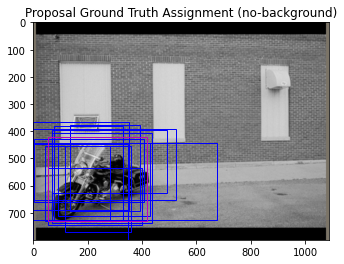

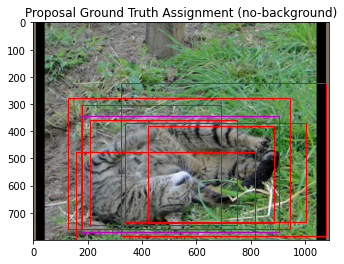

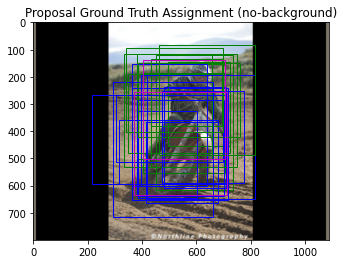

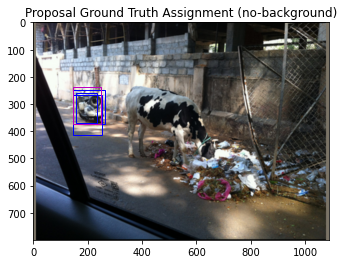

In [35]:
keep_topK = 200
with torch.no_grad():
  for iter, batch in enumerate(train_loader, 0):
    if iter % 2 == 1:
      continue
    if iter == 8:
      break
    images = batch['images'].cuda() # (bz, 3, 800, 1088)
    bboxes = batch['bbox'] # len(bz) {(n_obj, 4)}
    labels = batch['labels']

    # Take the features from the backbone
    backout = backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]] # list:len(bz) {(keep_topK,4)}
    labels_assigned,_ = boxHead.create_ground_truth(proposals,labels,bboxes)
    # Visualization
    for batch_idx in range(len(images)):
      # Image
      img_squeeze = transforms.functional.normalize(images[batch_idx].to('cpu'),
                                                                [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                                [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
      fig, ax = plt.subplots(1,1)
      ax.imshow(img_squeeze.permute(1,2,0))
      ax.set_title("Proposal Ground Truth Assignment (no-background)")
      # Extract redicted bbox and GT-bbox
      proposal = proposals[batch_idx].cpu().numpy() # (post_NMS_boxes_per_image, 4) 
      gt_bbox = bboxes[batch_idx].cpu().numpy()
      cmap = ['b', 'g', 'r']
      annotation = ['Vehicle','People','Animal']
      # Visualize predicted bbox
      for ith in range(len(proposal)):
        box = proposal[ith]
        if labels_assigned[ith] == 0:
          continue
        cmap_color = cmap[labels_assigned[ith] - 1]
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color=cmap_color)
        ax.add_patch(rect)
      # Visualize GT-bbox
      for gt_box in gt_bbox:
        rect = patches.Rectangle((gt_box[0],gt_box[1]),gt_box[2]-gt_box[0],gt_box[3]-gt_box[1],fill=False,color='m')
        ax.add_patch(rect)
      plt.show()

#### **2. Training and Validation curves**

Text(0.5, 1.0, 'Regression training loss')

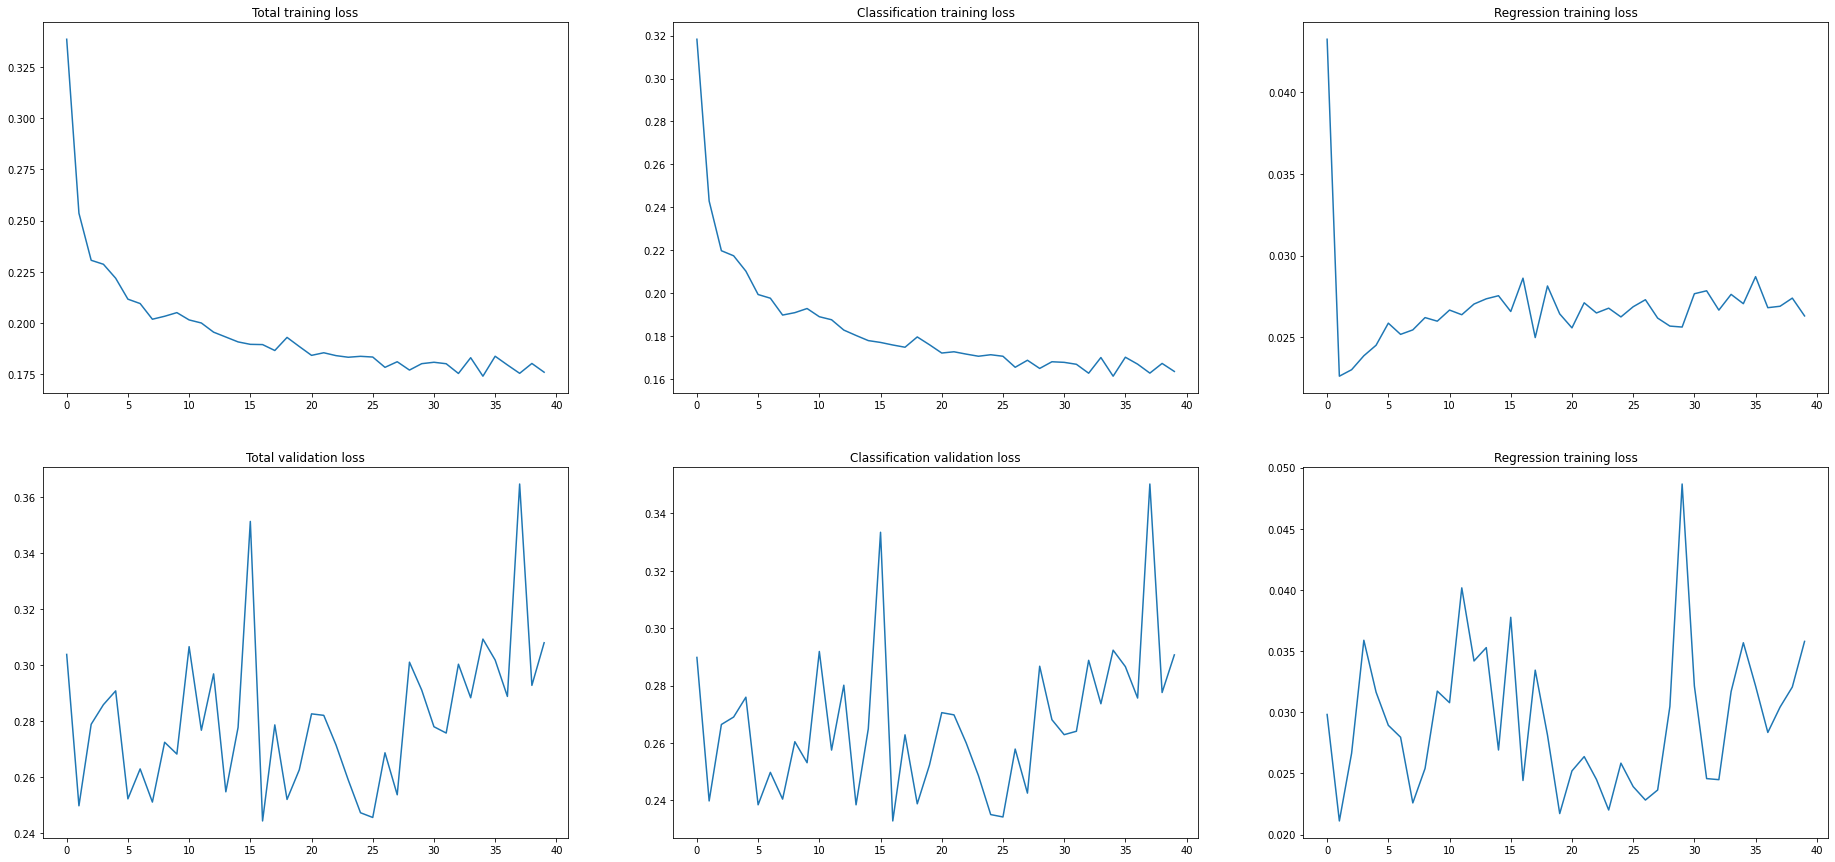

In [4]:
train_loss = np.load("result/train_loss.npy")
train_cls_loss = np.load("result/cls_loss.npy")
train_reg_loss = np.load("result/reg_loss.npy")
val_loss = np.load("result/val_loss.npy")
val_cls_loss = np.load("result/val_cls_loss.npy")
val_reg_loss = np.load("result/val_reg_loss.npy")
fig, ax = plt.subplots(2,3,figsize=(32,15))
ax[0,0].plot(train_loss)
ax[0,0].set_title('Total training loss')
ax[0,1].plot(train_cls_loss)
ax[0,1].set_title('Classification training loss')
ax[0,2].plot(train_reg_loss)
ax[0,2].set_title('Regression training loss')
ax[1,0].plot(val_loss)
ax[1,0].set_title('Total validation loss')
ax[1,1].plot(val_cls_loss)
ax[1,1].set_title('Classification validation loss')
ax[1,2].plot(val_reg_loss)
ax[1,2].set_title('Regression training loss')

#### **3. Top 20 boxes produced by Boxhead in test set**

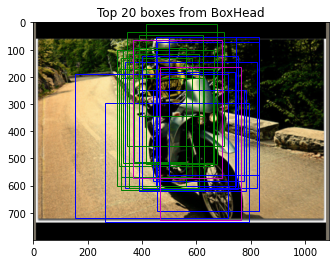

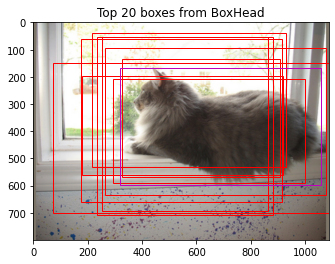

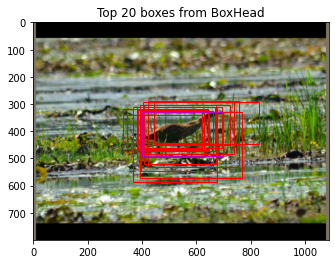

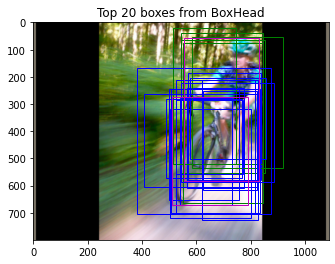

In [13]:
keep_topK = 200
with torch.no_grad():
  for iter, batch in enumerate(test_loader, 0):
    if iter % 2 == 1:
      continue
    if iter == 8:
      break
    images = batch['images'].cuda() # (bz, 3, 800, 1088)
    bboxes = batch['bbox'] # len(bz) {(n_obj, 4)}

    # Take the features from the backbone
    backout = backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]] # list:len(bz) {(keep_topK,4)}
    fpn_feat_list = list(backout.values()) # list:len(FPN) {(bz,256,H_feat,W_feat)}
    # Forward output from boxHead model
    feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list, proposals)
    pred_class, pred_coord = boxHead.forward(feature_vectors, eval=True)
    # Post-processing
    pred_bboxes, pred_scores, pred_labels = boxHead.postprocess_detections(pred_class, pred_coord, proposals, keep_num_preNMS=20, apply_NMS=False)
    # Visualization
    for batch_idx in range(len(pred_bboxes)):
      # Image
      img_squeeze = transforms.functional.normalize(images[batch_idx].to('cpu'),
                   [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                   [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
      fig, ax = plt.subplots(1,1)
      ax.set_title("Top 20 boxes from BoxHead")
      ax.imshow(img_squeeze.permute(1,2,0))
      # Extract redicted bbox and GT-bbox
      pred_bbox = pred_bboxes[batch_idx] # (post_NMS_boxes_per_image, 4)
      pred_label = pred_labels[batch_idx]
      gt_bbox = bboxes[batch_idx] # (n_obj, 4)
      cmap = ['b', 'g', 'r']
      annotation = ['Vehicle','People','Animal']
      # Visualize predicted bbox
      for pred_ith in range(len(pred_bbox)):
        pred_box = pred_bbox[pred_ith]
        cmap_color = cmap[pred_label[pred_ith] - 1]
        rect = patches.Rectangle((pred_box[0],pred_box[1]),pred_box[2]-pred_box[0],pred_box[3]-pred_box[1],fill=False,color=cmap[pred_label[pred_ith]-1])
        ax.add_patch(rect)
    # Visualize GT-bbox
    for gt_box in gt_bbox:
      rect = patches.Rectangle((gt_box[0],gt_box[1]),gt_box[2]-gt_box[0],gt_box[3]-gt_box[1],fill=False,color='m')
      ax.add_patch(rect)
    plt.show()

#### **4. P-R curve, APs and mAP**

In [69]:
# batch_size = 1 assumption 
keep_topK = 200
all_curve = []
AP_total = 0
for class_label in [1,2,3]:
  total_gt_bbox_num = 0
  total_conf = []
  total_pre_TP = []
  total_recall_TP = []
  precision, recall = [], []
  with torch.no_grad():
    for iter, batch in enumerate(tqdm(test_loader), 0):
      images = batch['images'].cuda() # (1, 3, 800, 1088)
      bboxes = batch['bbox'][0]       # (n_obj, 4)
      labels = batch['labels'][0]     # (n_obj,)
      # Take the features from the backbone
      backout = backbone(images)
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
      rpnout = rpn(im_lis, backout)
      proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]] # list:len(bz) {(keep_topK,4)}
      fpn_feat_list = list(backout.values()) # list:len(FPN) {(bz,256,H_feat,W_feat)}
      # Forward output from boxHead model and post-processing
      feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list, proposals)
      pred_class, pred_coord = boxHead.forward(feature_vectors, eval=True)
      pred_bboxes, pred_scores, pred_labels = boxHead.postprocess_detections(pred_class, pred_coord, proposals, keep_num_preNMS=100, keep_num_postNMS=50)
      pred_bboxes, pred_scores, pred_labels = pred_bboxes[0], pred_scores[0].cpu(), pred_labels[0].cpu()
      # Get gt bbox 
      gt_index = torch.nonzero(labels == class_label).flatten()
      gt_label = labels[gt_index]
      gt_bbox = bboxes[gt_index]
      total_gt_bbox_num += len(gt_bbox)
      # Get prediction bbox
      pred_index = torch.nonzero(pred_labels == class_label).flatten()
      pred_bbox = pred_bboxes[pred_index]
      pred_score = pred_scores[pred_index]
      pred_label = pred_labels[pred_index]
      ## Case 1: No gt-bbox in this class_label
      if len(gt_bbox) == 0:
        for pred_bbox_idx in range(len(pred_bbox)):
          total_pre_TP.append(0)
          total_recall_TP.append(0)
          total_conf.append(pred_score[pred_bbox_idx].item())
      ## Case 2: Both gt-bbox and pred-bbox exist
      elif len(pred_bbox) != 0:
        pred_conf = pred_score.tolist()
        total_conf.extend(pred_conf)
        # Calculate cross IOU with GT
        cross_IoU = IOU_xyxy(pred_bbox, gt_bbox).numpy()
        score_sort_index = np.argsort(pred_conf)[::-1] # Descending order
        IOU_sort = cross_IoU[score_sort_index]
        # TP & FP binary map
        TPFP_map = (IOU_sort > 0.5).astype(int)
        for ii in range(TPFP_map.shape[0]):
          if 1 in TPFP_map[ii]:
            # Precision check
            total_pre_TP.append(1)
            # Recall check
            tru_idx = np.argwhere(TPFP_map[ii] == 1)[0]
            if np.sum(TPFP_map[:ii+1,tru_idx]) == 1:
              total_recall_TP.append(1)
            else:
              total_recall_TP.append(0)
          else:
            total_pre_TP.append(0)
            total_recall_TP.append(0)
    # Sort all proposals confidence and calculate AP
    score_sort_index_total = np.argsort(total_conf)[::-1]
    total_pre_TP = np.array(total_pre_TP)[score_sort_index_total]
    total_recall_TP = np.array(total_recall_TP)[score_sort_index_total]
    for ii in range(len(total_conf)):
      precision.append(sum(total_pre_TP[:ii+1])/(ii+1))
      recall.append(sum(total_recall_TP[:ii+1])/total_gt_bbox_num)
        # Calculate current class AP
    AP_class = np.sum((np.array(recall[1:]) - np.array(recall[:-1])) * np.array(precision[1:]))
    print(AP_class)
    AP_total += AP_class
    all_curve.append([precision, recall])

100%|██████████| 653/653 [01:22<00:00,  7.88it/s]


0.6517841210415255


100%|██████████| 653/653 [01:24<00:00,  7.77it/s]


0.7294300003860926


100%|██████████| 653/653 [01:24<00:00,  7.70it/s]

0.707334184582196


mAP: 0.6962


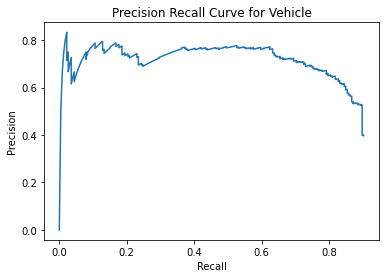

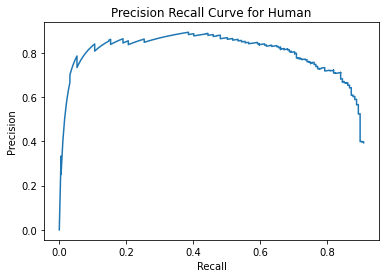

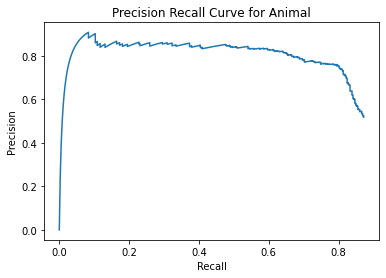

In [93]:
category = {0:'Vehicle', 1:'Human', 2:'Animal'}
print('mAP: %.4f' %(AP_total/3))
for class_idx in range(3):
    plt.figure()
    plt.plot(all_curve[class_idx][1], all_curve[class_idx][0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve for %s' % (category[class_idx]))

#### **5. Results after Post Processing**

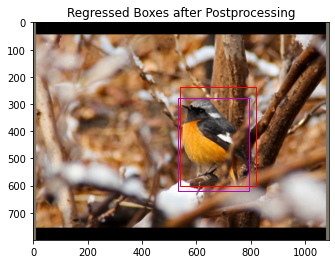

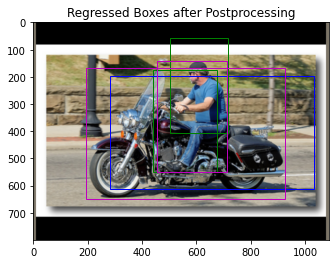

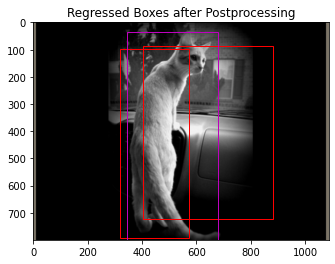

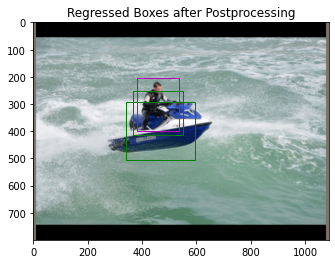

In [29]:
keep_topK = 20
with torch.no_grad():
  for iter, batch in enumerate(test_loader, 0):
    if iter % 2 == 1:
      continue
    elif iter == 8:
      break
    images = batch['images'].cuda() # (bz, 3, 800, 1088)
    bboxes = batch['bbox'] # len(bz) {(n_obj, 4)}

    # Take the features from the backbone
    backout = backbone(images)
    im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
    rpnout = rpn(im_lis, backout)
    proposals = [proposal[0:keep_topK,:] for proposal in rpnout[0]] # list:len(bz) {(keep_topK,4)}
    fpn_feat_list = list(backout.values()) # list:len(FPN) {(bz,256,H_feat,W_feat)}
    # Forward output from boxHead model
    feature_vectors = boxHead.MultiScaleRoiAlign(fpn_feat_list, proposals)
    pred_class, pred_coord = boxHead.forward(feature_vectors, eval=True)
    # Post-processing
    pred_bboxes, pred_scores, pred_labels = boxHead.postprocess_detections(pred_class, pred_coord, proposals)
    # Visualization
    for batch_idx in range(len(pred_bboxes)):
      # Image
      img_squeeze = transforms.functional.normalize(images[batch_idx].to('cpu'),
                                                                [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                                                [1 / 0.229, 1 / 0.224, 1 / 0.225], inplace=False)
      fig, ax = plt.subplots(1,1)
      ax.imshow(img_squeeze.permute(1,2,0))
      ax.set_title("Regressed Boxes after Postprocessing")
      # Extract redicted bbox and GT-bbox
      pred_bbox = pred_bboxes[batch_idx] # (post_NMS_boxes_per_image, 4)
      pred_label = pred_labels[batch_idx]
      gt_bbox = bboxes[batch_idx] # (n_obj, 4)
      cmap = ['b', 'g', 'r']
      annotation = ['Vehicle','People','Animal']
      # Visualize predicted bbox
      for pred_ith in range(len(pred_bbox)):
        pred_box = pred_bbox[pred_ith]
        cmap_color = cmap[pred_label[pred_ith] - 1]
        rect = patches.Rectangle((pred_box[0],pred_box[1]),pred_box[2]-pred_box[0],pred_box[3]-pred_box[1],fill=False,color=cmap[pred_label[pred_ith]-1])
        ax.add_patch(rect)
      # Visualize GT-bbox
      for gt_box in gt_bbox:
        rect = patches.Rectangle((gt_box[0],gt_box[1]),gt_box[2]-gt_box[0],gt_box[3]-gt_box[1],fill=False,color='m')
        ax.add_patch(rect)
    plt.show()